## **Name**: Harrison
## **Status**: UG2
## **Department**: CBE

# ***CBE 512. Machine Learning in Chemical Science and Engineering.***
## **Assignment 04:** *Neural Networks*
### &#169; Princeton University
### **DUE**: 11:59pm, November 01, 2024
### **Notes**: Supply responses/solutions in a packaged format, including notebook (.ipynb), .docx, or .pdf for your text, and .pdf for slides. Your assignment should be submitted to Canvas.



---
## **Problem 1 (100 points):**

Examine the contents of `concrete_data.csv` and the description in `readme.concrete_data.csv`.
You can download and view it on your own or easily examine the contents on github [here](https://raw.githubusercontent.com/webbtheosim/CBE512-MLinChmSciEng/main/data/concrete_data.csv) and [here](https://github.com/webbtheosim/CBE512-MLinChmSciEng/blob/main/data/readme.concrete_data.txt).

This is a dataset featuring 1030 experimental measurements that characterize the compressive strength of concrete that is distinguished by eight material descriptors: 'Cement', 'Blast Furnace Slag', 'Fly Ash', 'Water', 'Superplasticizer', 'Coarse Aggregate', 'Fine Aggregate', and 'Age'. The first seven descriptors reflect concentrations of components (kg per cubic meter of mixture) and the last is self-explanatory (units of days). All the data is "raw," so you should conduct your own preprocessing.

Overall, you are going to build and test neural networks to predict compressive strength of concrete from the materials descriptors. *For computational expediency, you may use simple train-test splits* in lieu of k-fold cross-validation for reporting.

If you are having trouble accomplishing the tasks with the amount of data provided, you can truncate the dataset as needed (e.g., use 200 points instead of 1000).

---


**(a)** Evaluate how training dataset size affects neural network performance using a dataset with over 1000 data points. Start by splitting the data into 80% training and 20% testing. **Keep the test set fixed for consistent evaluation**. From the training set, randomly sample different portions (e.g., 20%, 40%, 60%, etc.). For each subset, train a neural network using the architecture [200->100->50->10->1] with ReLU activations in all layers except the final one. Use the Adam optimizer, MSE loss, 500 epochs, and a batch size of 16, but feel free to adjust these.

After training, evaluate each model on the fixed test set. Plot test-set performance against training set size and analyze whether all data points are needed for effective results.

---

**Student's Response:**

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


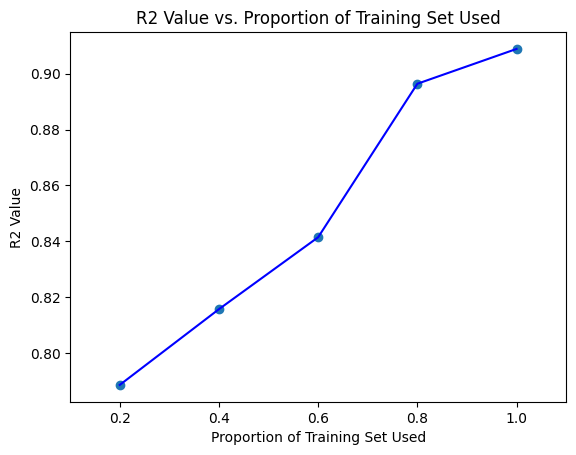

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt

keras.utils.set_random_seed(0)

url_for_data = "https://raw.githubusercontent.com/webbtheosim/CBE512-MLinChmSciEng/main/data/concrete_data.csv"
data = pd.read_csv(url_for_data)
X = np.array(data.loc[:, [col for col in data.columns if col != 'Concrete compressive strength']])
Y = np.array(data['Concrete compressive strength'])

(X_train, X_test, Y_train, Y_test) = train_test_split(X, Y, test_size = 0.2, random_state = 0)

inscaler = StandardScaler()
inscaler.fit(X_train)
Xs_train = inscaler.transform(X_train)
Xs_test = inscaler.transform(X_test)

outscaler = StandardScaler()
outscaler.fit(np.reshape(Y_train, (-1,1)))
Ys_train = outscaler.transform(np.reshape(Y_train, (-1, 1)))
Ys_test = outscaler.transform(np.reshape((Y_test), (-1, 1)))

nfeatures = X_train.shape[1]

r2_values = []

inputLayer = keras.Input(shape=(nfeatures,), name="input")
layer1 = layers.Dense(100, activation='relu', name='firstlayer')
layer2 = layers.Dense(50, activation='relu', name='secondlayer')
layer3 = layers.Dense(10, activation='relu', name='thirdlayer')
output = layers.Dense(1, activation=None, name='output')

outputs = output(layer3(layer2(layer1(inputLayer))))
props = [0.2, 0.4, 0.6, 0.8, 1]

for i in props:
  model = keras.Model(inputs=inputLayer, outputs = outputs, name='model')
  idx = np.random.choice(np.arange(len(X_train)), size = int(len(X_train) * i), replace=False)
  X_sample = Xs_train[idx]
  Y_sample = Ys_train[idx]
  the_optimizer = tf.keras.optimizers.Nadam()
  the_loss = keras.losses.MeanSquaredError(reduction="sum_over_batch_size")
  model.compile(optimizer = the_optimizer, loss = the_loss)
  model.fit(x=X_sample, y=Y_sample, batch_size = 16, epochs=500, validation_split = 0.2, verbose=0)
  Y_pred = model.predict(Xs_test)

  r2 = r2_score(Ys_test, Y_pred)
  r2_values.append(r2)


plt.plot(props, r2_values, 'o')
plt.plot(props, r2_values, color="blue")
plt.xlim([0.1,1.1])
plt.title("R2 Value vs. Proportion of Training Set Used")
plt.ylabel("R2 Value")
plt.xlabel("Proportion of Training Set Used")
plt.show()



**It seems that as the dataset proportion increases, the R2 value also increases. This implies that all of the points in the dataset are useful to increasing the accuracy of the model.**

**(b)** Technically, the number of epochs for training is an important hyperparameter for model construction. We have often mentioned the approach of "Early Stopping," for which training stops (or returns) back to the state that minimized the validation loss (usually to mitigate subsequent overfitting).

First, make a plot of the training and test set performance versus the number of epochs using the model that used 60% of the total available data for training. Is there a number of epochs for training for which the test loss reaches a minimum? Note that you can specify data for "validation" within the Keras API (rather than specifying the split ratio).

Next, use Keras's callback functionality to implement `EarlyStopping` and save the model as a .hdf5 format using `ModelCheckpoint`. For early stopping, you want to monitor `val_loss`, with `mode=min` and `patience=50`. Report what epoch yielded your best model. Should this be the same as what you saw in the previous run manual run?

Finally, use `load_model` to load in your saved best model, and report the MSE/R2 performance of your best early stopping model on the train/test set.

Early stopping implementation is described [here](https://keras.io/api/callbacks/early_stopping/). Model checkpoint [here](https://keras.io/api/callbacks/model_checkpoint/).

---

**Student's Response:**

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


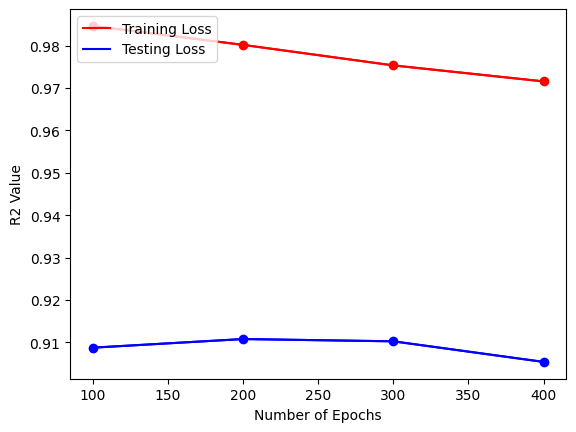

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Training Set
R2 Value: 0.9709887486486037
MSE Value: 0.029011251351396258


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Test Set
R2 Value: 0.9103296878152568
MSE Value: 0.08366975927993979


In [ ]:
from sklearn.metrics import mean_squared_error

dataset_size = int(len(X_train) * 0.6)
idx = np.random.RandomState(0).choice(np.arange(len(X_train)), size = dataset_size, replace=False)
model = keras.Model(inputs=inputLayer, outputs = outputs, name='model')
X_sample = Xs_train[idx]
Y_sample = Ys_train[idx]

r2_test = []
r2_train = []

epochs = [100, 200, 300, 400]
keras.utils.set_random_seed(0)
the_optimizer = tf.keras.optimizers.Nadam()
the_loss = keras.losses.MeanSquaredError(reduction="sum_over_batch_size")

for i in epochs:
  model.compile(optimizer = the_optimizer, loss = the_loss)
  model.fit(x=X_sample, y=Y_sample, batch_size = 16, epochs=i, validation_split = 0.2, verbose=0)
  Y_predtrain = model.predict(Xs_train)
  Y_predtest = model.predict(Xs_test)
  r2_train.append(r2_score(Ys_train, Y_predtrain))
  r2_test.append(r2_score(Ys_test, Y_predtest))

plt.plot(epochs, r2_train, marker='o', color='r')
plt.plot(epochs, r2_train, color='r', label="Training Loss")
plt.plot(epochs, r2_test, marker='o', color='b')
plt.plot(epochs, r2_test, color='b', label="Testing Loss")
plt.xlabel("Number of Epochs")
plt.ylabel("R2 Value")
plt.legend(loc='upper left')
plt.show()


model.compile(optimizer = the_optimizer, loss = the_loss)

callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 50, mode="min")
checkpoint_filepath = '/tmp/ckpt/checkpoint.model.keras'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

model.fit(x=X_sample, y=Y_sample, batch_size = 16, validation_split=0.2, epochs = 500, callbacks=[callback, checkpoint_callback], verbose = 0)

y_pred = model.predict(Xs_train)
r2 = r2_score(Ys_train, y_pred)
mse = mean_squared_error(Ys_train, y_pred)
print("Training Set")
print("R2 Value: " + str(r2))
print("MSE Value: " + str(mse))

print()
print()

model = keras.models.load_model(checkpoint_filepath)
y_pred = model.predict(Xs_test)
r2 = r2_score(Ys_test, y_pred)
mse = mean_squared_error(Ys_test, y_pred)
print("Test Set")
print("R2 Value: " + str(r2))
print("MSE Value: " + str(mse))

**(c)** We have not talked significantly about weight initialization for neural networks. During model optimization, we are trying identify the weights that minimize our target loss -- this process is guided through backpropogation. Like most optimizations, success can depend on initial guesses. With neural networks, the process is confounded by the so-called vanishing/exploding gradient problem.

Early work in weight initialization helped mitigate that problem by being smarter about initialization.
Let's explore a little bit about how our weight initialization choices can influence model convergence. Make a bar plot of the train/test performance of your neural network model using three settings for the weight initialization: ["zeros", "RandomUniform", "GlorotUniform","HeNormal"]. Comment on any tangible observations.

The initializers are described [here](https://keras.io/api/layers/initializers/).

---

**Student's Response:**

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
[-0.005685653122251999, 0.8502841762036016, 0.8410068387202909, 0.8427253492593278]
[-0.0001290329241825372, 0.915346354087581, 0.9212687660262698, 0.9161628686702318]


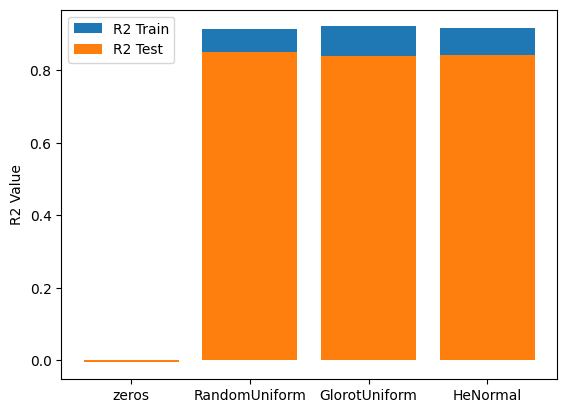

In [ ]:
from keras import initializers

initializers = ["zeros", "RandomUniform", "GlorotUniform", "HeNormal"]

keras.utils.set_random_seed(0)

r2_train = []
r2_test = []

dataset_size = int(len(X_train) * 0.6)
idx = np.random.RandomState(0).choice(np.arange(len(X_train)), size = dataset_size, replace=False)
Xs_sample = Xs_train[idx]
Ys_sample = Ys_train[idx]

for string in initializers:
  the_optimizer = tf.keras.optimizers.Nadam()
  the_loss = keras.losses.MeanSquaredError(reduction="sum_over_batch_size")
  inputLayer1 = keras.Input(shape=(X_sample.shape[1],), name="input1")
  layer1 = layers.Dense(100, activation='relu', name='firstlayer1', kernel_initializer = string)
  layer2 = layers.Dense(50, activation='relu', name='secondlayer1', kernel_initializer = string)
  layer3 = layers.Dense(10, activation='relu', name='thirdlayer1', kernel_initializer = string)
  output1 = layers.Dense(1, activation=None, name='output1', kernel_initializer = string)
  outputs = output(layer3(layer2(layer1(inputLayer1))))

  modelnew = keras.Model(inputs=inputLayer1, outputs = outputs, name='modelnew')
  modelnew.compile(optimizer = the_optimizer, loss = the_loss)
  modelnew.fit(x=Xs_sample, y=Ys_sample, batch_size = 16, epochs=300, validation_split = 0.2, verbose=0)
  Y_predtrain = modelnew.predict(Xs_train)
  Y_predtest = modelnew.predict(Xs_test)
  r2_train.append(r2_score(Ys_train, Y_predtrain))
  r2_test.append(r2_score(Ys_test, Y_predtest))

print(r2_test)
print(r2_train)

plt.bar(initializers, r2_train)
plt.bar(initializers, r2_test)
plt.legend(["R2 Train", "R2 Test"])
plt.ylabel("R2 Value")
plt.show()

**It looks like the random uniform, the glorot uniform, and the henormal initialization models are all approximately equivalent, whereas the zeros method performs very poorly.**

**(d)** You have been working with a simple feedforward neural network using Keras’s `Sequential` model. Now, modify your network architecture using Keras’s `Model` functional API to introduce branching and layer concatenation. For example, implement a skip (residual) connection, where the input from an earlier layer bypasses intermediate layers and is added to the output of a later layer. This architecture can help mitigate the vanishing gradient problem and improve training, especially in deeper networks.

Train the modified model using the same settings (Adam optimizer, MSE loss, 500 epochs), with 60% of the total data for training, and use `EarlyStopping` with `ModelCheckpoint`. Compare the performance of this model on the test set to your original model's performance.


The Model functional API is described [here](https://keras.io/guides/functional_api/).

---

**Student's Response:**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras import initializers
from sklearn.metrics import mean_squared_error

keras.utils.set_random_seed(0)

dataset_size = int(len(X_train) * 0.6)
idx = np.random.RandomState(0).choice(np.arange(len(X_train)), size = dataset_size, replace=False)
Xs_sample = Xs_train[idx]
Ys_sample = Ys_train[idx]

callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 50, mode="min")
checkpoint_filepath = '/tmp/ckpt/checkpoint.splitmodel.keras'
checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

the_optimizer = tf.keras.optimizers.Nadam()
the_loss = keras.losses.MeanSquaredError(reduction="sum_over_batch_size")

inputLayer = keras.Input(shape=(Xs_sample.shape[1],), name="add1")
layer1 = layers.Dense(100, activation='relu', name='c1')
layer2 = layers.Dense(50, activation='relu', name='c2')
layer3 = layers.Dense(Xs_sample.shape[1], activation='relu', name='c3')
output = layers.Dense(1, activation=None, name='c4')

xs = layer3(layer2(layer1(inputLayer)))

outputs = output(layers.add([xs, inputLayer]))

model = keras.Model(inputs=inputLayer, outputs = outputs, name="model")

model.compile(optimizer = the_optimizer, loss = the_loss)
model.fit(x=Xs_sample, y=Ys_sample, batch_size = 16, epochs = 500, validation_split = 0.2, callbacks=[callback, checkpoint_callback], verbose = 0)

y_predtrain = model.predict(Xs_train)
y_predtest = model.predict(Xs_test)
print("R2 Score for Training Set")
print(r2_score(Ys_train, y_predtrain))
print()
print("R2 Score for Test Set")
print(r2_score(Ys_test, y_predtest))


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R2 Score for Training Set
0.933316560165565

R2 Score for Test Set
0.8753469689483426


**Compared to the model I made in part b, it seems that this model performs worse in the training and test sets.**

**(e)** Dropout is a regularization technique used to reduce overfitting in neural networks by randomly deactivating units during training. Modify your existing model by adding `Dropout` layers after each Dense layer (except the output layer) with dropout rates of 0.2 and 0.5. Train the modified model using the same settings (Adam optimizer, MSE loss, 500 epochs) and architecture as in part **b**, with 60% of the total data for training, and use `EarlyStopping` with `ModelCheckpoint`.

Compare the test set performance with the baseline model (no Dropout). How does Dropout affect generalization, and what dropout rate yields the best results?

The Dropout layer is described [here](https://keras.io/api/layers/regularization_layers/dropout/).

---

**Student's Response:**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score
import tensorflow as tf
from tensorflow import keras
from keras import layers
import matplotlib.pyplot as plt
from keras import initializers
from sklearn.metrics import mean_squared_error

keras.utils.set_random_seed(0)

dataset_size = int(len(X_train) * 0.6)
idx = np.random.RandomState(0).choice(np.arange(len(X_train)), size = dataset_size, replace=False)
Xs_sample = Xs_train[idx]
Ys_sample = Ys_train[idx]

nums = [0.2, 0.5]
for i in nums:
  callback = keras.callbacks.EarlyStopping(monitor="val_loss", patience = 50, mode="min")
  checkpoint_filepath = '/tmp/ckpt/checkpoint.splitmodel.keras'
  checkpoint_callback = keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, monitor='val_loss', mode='min', save_best_only=True)

  the_optimizer = tf.keras.optimizers.Nadam()
  the_loss = keras.losses.MeanSquaredError(reduction="sum_over_batch_size")

  inputLayer = keras.Input(shape=(Xs_sample.shape[1],), name="add1")
  inputlayerdropout = layers.Dropout(i)
  layer1 = layers.Dense(100, activation='relu', name='c1', kernel_initializer = 'RandomUniform')
  layer1dropout = layers.Dropout(i)
  layer2 = layers.Dense(50, activation='relu', name='c2', kernel_initializer = 'RandomUniform')
  layer2dropout = layers.Dropout(i)
  layer3 = layers.Dense(Xs_sample.shape[1], activation='relu', name='c3', kernel_initializer = 'RandomUniform')
  layer3dropout = layers.Dropout(i)
  output = layers.Dense(1, activation=None, name='c4', kernel_initializer = 'RandomUniform')

  xs = layer3dropout(layer3(layer2dropout(layer2(layer1dropout(layer1(inputlayerdropout(inputLayer)))))))

  outputs = output(layers.add([xs, inputlayerdropout(inputLayer)]))

  model = keras.Model(inputs=inputLayer, outputs = outputs, name="model")

  model.compile(optimizer = the_optimizer, loss = the_loss)
  model.fit(x=Xs_sample, y=Ys_sample, batch_size = 16, epochs = 500, validation_split = 0.2, callbacks=[callback, checkpoint_callback], verbose = 0)

  y_predtrain = model.predict(Xs_train)
  y_predtest = model.predict(Xs_test)
  print("R2 Score for Training Set for {}".format(i))
  print(r2_score(Ys_train, y_predtrain))
  print()
  print("R2 Score for Test Set for {}".format(i))
  print(r2_score(Ys_test, y_predtest))


26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R2 Score for Training Set for 0.2
0.8043582896602549

R2 Score for Test Set for 0.2
0.7816206178362732
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
R2 Score for Training Set for 0.5
0.6083909219019401

R2 Score for Test Set for 0.5
0.6139340901573429


**It seems that using dropout increases generalizability because the test and training R2 values were closer to each other when dropout is included. However, as a tradeoff, it seems the overall R2 value was decreased. A dropout rate of 0.2 produces the best results, but it is still significantly worse than my original model in part b.**